## Ab initio PES

The Hamiltonian for the Morse oscillator can be written as
\begin{equation}
̂\hat{H} = -\frac{\hbar^2}{2\mu} \frac{d^2}{dr^2} + V_{Morse}(r), \tag{1}
\end{equation}
where 
\begin{equation}
V_{Morse}(r) = D_e \left(1 - e^{-\beta(r-r_{eq})} \right)^2. \tag{2}
\end{equation}

r array
[0.5        0.59858051 0.69716102 0.79574153 0.89432204 0.99290255
 1.09148306 1.19006357 1.28864408 1.38722459 1.4858051  1.58438561
 1.68296611 1.78154662 1.88012713 1.97870764 2.07728815 2.17586866
 2.27444917 2.37302968 2.47161019 2.5701907  2.66877121 2.76735172
 2.86593223 2.96451274 3.06309325 3.16167376 3.26025427 3.35883478
 3.45741529 3.5559958  3.65457631 3.75315682 3.85173732 3.95031783
 4.04889834 4.14747885 4.24605936 4.34463987 4.44322038 4.54180089
 4.6403814  4.73896191 4.83754242 4.93612293 5.03470344 5.13328395
 5.23186446 5.33044497]
xp array
[0.5        0.51396413 0.55565288 0.62445835 0.7193772  0.83902528
 0.98165787 1.14519506 1.32725211 1.52517422 1.73607523 1.95687974
 2.18436792 2.41522248 2.64607704 2.87356523 3.09436974 3.30527075
 3.50319286 3.68524991 3.8487871  3.99141969 4.11106777 4.20598662
 4.27479208 4.31648084 4.33044497]
1.561062667389548
1.5610613707135599


(-0.1, 1.0)

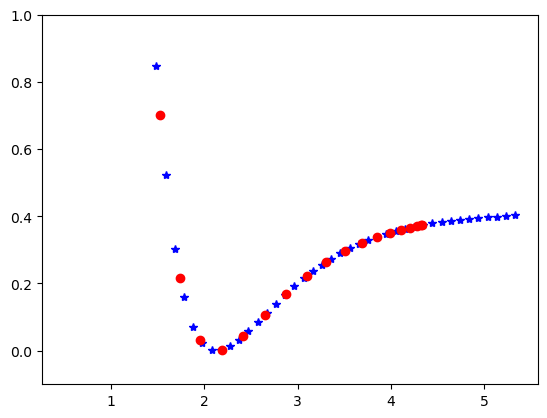

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import hermite
from math import factorial
# import pyscf libraries
from pyscf import scf
import pyscf
from pyscf import gto, cc
from scipy import interpolate
from numpy.polynomial import chebyshev as C

# define constants
De= 0.4125169968027636
r_eq = 2.132177987349192
beta = 1.3755432414187434
k_morse = 2 * De * beta ** 2

# minimum and max x-values to evaluate Morse on
xp_0 = 0.5
xp_Nml = 2.5 * r_eq

# uniform array of bondlength values
r_array = np.linspace(xp_0, xp_Nml, 50)

# N - order of polynomial
N = 27

# k-coordinate for Libatto grid
k = np.linspace(0, N-1, N, dtype=int)
# Libatto grid on domain [-1,1]
xk = -np.cos(k * np.pi / (N - 1))

# transformation of Libatto grid to xp grid -> xp = m*xk + b
b = (xp_Nml - xp_0) / 2
slope = b - xp_0

xp_array = slope * xk + b

print("r array")
print(r_array)
print("xp array")
print(xp_array)

# array of Morse potential values
V_Morse = De * (1 - np.exp(-beta * (r_array - r_eq))) ** 2
V_Libatto = De * (1 - np.exp(-beta * (xp_array - r_eq))) ** 2


c, stats = C.chebfit(xp_array, V_Libatto, N, full=True)
  
#print('coefficients are :'+str(c))
#print('residuals '+str(stats[0]))
#print('rank :'+str(stats[1]))
#print('singular_values :'+str(stats[2]))
#print('rcond: '+str(stats[3]))

fit = C.chebval(xp_array, c, tensor=True)

c_pp = C.chebder(c, m=2, scl=1)
k_cheb = C.chebval(r_eq, c_pp)

print(k_morse)
print(k_cheb)
print("")

plt.plot(r_array, V_Morse, 'b*')
plt.plot(xp_array, V_Libatto, 'ro')
plt.ylim(-0.1, 1)



In [ ]:
# plot the Morse potential
plt.plot(r_array, V_Morse, label="V$_{Morse}$")
plt.ylabel("Potential (a.u.)")
plt.xlabel("Bondlength (Bohr)")
plt.xlim(0.5 * r_eq, 2 * r_eq)
plt.ylim(0, 1)
plt.legend()
plt.show()

# Install pyscf quantum chemistry package

In [ ]:
!pip install pyscf

# Run a quick potential energy scan of the CO molecule

In [ ]:




# define molecule class
mol = gto.Mole()
# use Bohr units for the geometry
mol.unit = 'B'
# create a base geometry string that we can modify to perform the scan
mol_base = '''
    C   0. 0. 0.
    O  0. 0.  **R**
'''

# perform the scan over the values in r_array 
RHF_E_array = []
RHF_E_array_offset = []
#CCSD_E_array = []
mol.basis = 'ccpvdz'
for r in r_array:
  mol_str = mol_base.replace("**R**", str(r))
  mol.atom = mol_str
  mol.build()
  myhf = mol.HF()
  myhf.kernel()
  #mycc = cc.CCSD(myhf).run()
  #print('CCSD total energy', mycc.e_tot)
  #et = mycc.ccsd_t()
  
  #append to E_array - offset by minimum energy to align with Morse model
  RHF_E_array_offset.append(myhf.e_tot+112.75014721195242)
  #CCSD_E_array.append(mycc.e_tot  + et)
  RHF_E_array.append(myhf.e_tot)
  


In [ ]:
#ccnp = np.array(CCSD_E_array)
#ccnp += 112.749832486117
# plot the PES against the Morse model
plt.plot(r_array, RHF_E_array_offset, color="red", label='V$_{HF}$')
#plt.plot(r_array, CCSD_E_array, color="blue", label="V$_{Morse}$")
plt.ylabel("Potential (a.u.)")
plt.xlabel("Bondlength (Bohr)")
plt.xlim(1.25, 3)
plt.ylim(0, 1)
#plt.ylim(-113.25, -112.2)
plt.legend()
plt.show()


In [ ]:
# get the equilibrium bond length from each level of theory
RHF_E_array_np = np.array(RHF_E_array)
#CC_E_array_np = np.array(CCSD_E_array)


#hf_idx = np.argmin(RHF_E_array_np)
hf_idx = np.argmin(V_Morse)

r_eq_hf = r_array[hf_idx]

#cc_idx = np.argmin(CC_E_array_np)
#r_eq_cc = r_array[cc_idx]

# HF equilibrium r in atomic units
print(r_eq_hf)
#print(r_eq_cc)
#V0_hf = RHF_E_array[hf_idx]
V0_hf = V_Morse[hf_idx]
print(V0_hf)

dr = r_array[hf_idx + 1] - r_array[hf_idx - 1]
dV = V_Morse[hf_idx + 1] - V_Morse[hf_idx - 1]
k = dV/dr
print(k)

In [ ]:
print(r_array[250:350])
plt.plot(r_array[250:350], V_Morse[250:350], color="red", label='V$_{HF}$')
#plt.plot(r_array, CCSD_E_array, color="blue", label="V$_{Morse}$")
plt.ylabel("Potential (a.u.)")
plt.xlabel("Bondlength (Bohr)")
plt.xlim(1.25, 3)
plt.ylim(0, 1)
#plt.ylim(-113.25, -112.2)
plt.legend()
plt.show()


In [ ]:
# compute k of HF using centered fininte differences
#rhf_spline = interpolate.UnivariateSpline(r_array, RHF_E_array, k=3)
rhf_spline = interpolate.UnivariateSpline(r_array[250:350], V_Morse[250:350], k=3)
#cc_spline = interpolate.UnivariateSpline(r_array, CC_E_array_np, k=4)

rhf_f_spline = rhf_spline.derivative()
#cc_f_spline = cc_spline.derivative()

rhf_c_spline = rhf_f_spline.derivative()
#cc_c_spline = cc_f_spline.derivative()

k_hf = rhf_c_spline(r_eq_hf)
#k_cc = cc_c_spline(r_eq_cc)

print(k_hf)
#print(k_cc)

# compute Harmonic potential
V_hf_harm = 0.5 * k_hf * (r_array - r_eq_hf) ** 2 # + rhf_spline(r_eq_hf)

# get reduced mass of CO
m_O = 1836. * 16.
m_C = 1836. * 12.01
mu = (m_O * m_C)/(m_O + m_C)
print(mu)
# compute fundamental frequencies -> atomic units right now
nu_hf = 1 / (2 * np.pi) * np.sqrt( k_hf / mu)
#nu_cc = 1 / (2 * np.pi) * np.sqrt( k_cc / mu)

In [ ]:
def compute_alpha(k, mu, hbar):
    """ Helper function to compute \alpha = \sqrt{k * \omega / \hbar}
    
    Arguments
    ---------
    k : float
        the Harmonic force constant
        
    mu : float
        the reduced mass
        
    hbar : float
        reduced planck's constant
        
    Returns
    -------
    alpha : float
        \alpha = \sqrt{k * \omega / \hbar}
    
    """
    # compute omega
    omega = np.sqrt( k / mu )
    
    # compute alpha
    alpha =  mu * omega / hbar
    
    # return alpha
    return alpha

def N(n, alpha):
    """ Helper function to take the quantum number n of the Harmonic Oscillator and return the normalization constant
        
    Arguments
    ---------
    n : int
        the quantum state of the harmonic oscillator
        
    Returns
    -------
    N_n : float
        the normalization constant
    """
    
    return  np.sqrt( 1 / (2 ** n * factorial(n)) ) * ( alpha / np.pi ) ** (1/4) 

def psi(n, alpha, r, r_eq):
    """ Helper function to evaluate the Harmonic Oscillator energy eigenfunction for state n
        
    Arguments
    ---------
    n : int
        the quantum state of the harmonic oscillator
        
    alpha : float
        alpha value
        
    
    r : float
        position at which psi_n will be evaluated
        
    r_eq : float
        equilibrium bondlength
        
    Returns
    -------
    psi_n : float
        value of the harmonic oscillator energy eigenfunction
        
    """
    
    Hr = hermite(n)
    
    psi_n = N(n, alpha) * Hr( np.sqrt(alpha) * ( r - r_eq )) * np.exp( -0.5 * alpha  * (r - r_eq)**2)
    
    return psi_n

def harmonic_eigenvalue(n, k, mu, hbar):
    """ Helper function to evaluate the energy eigenvalue of the harmonic oscillator for state n"""
    
    return hbar * np.sqrt(k/mu) * (n + 1/2)

def morse_eigenvalue(n, k, mu, De, hbar):
    """ Helper function to evaluate the energy eigenvalue of the Morse oscillator for state n"""
    
    omega = np.sqrt( k / mu )
    xi = hbar * omega / (4 * De)

    return hbar * omega * ( (n + 1/2) - xi * (n + 1/2) ** 2)

def potential_matrix_element(n, m, alpha, r, r_eq, V_p):
    """ Helper function to compute <n|V_p|m> where V_p is the perturbing potential
    
    Arguments
    ---------
    n : int
        quantum number of the bra state
        
    m : int
        quantum number of the ket state
        
    alpha : float
        alpha constant for bra/ket states
        
    r : float
        position grid for bra/ket states
        
    r_eq : float
        equilibrium bondlength for bra/ket states
        
    V_p : float
        potential array
        
    Returns
    -------
    V_nm : float
        <n | V_p | m > 
    
    """
    # bra 
    psi_n = psi(n, alpha, r, r_eq)
    
    # ket 
    psi_m = psi(m, alpha, r, r_eq)
    
    # integrand
    integrand = np.conj(psi_n) * V_p * psi_m
    
    # integrate
    V_nm = np.trapz(integrand, r)
    
    return V_nm

In [ ]:
# compute alpha values in atomic units
alpha_hf = compute_alpha(k_hf, mu, 1)
#alpha_cc = compute_alpha(k_cc, mu, 1)

print(alpha_hf)
print(r_eq_hf)
# compute psi_0 along the r grid
psi_0 = psi(50, alpha_hf, r_array, r_eq_hf)

# is it normalized?
Integral = np.trapz(psi_0 ** 2, r_array)
print(Integral)
#assert np.isclose(Integral, 1.0)


# Harmonic potential
plt.plot(r_array, psi_0, label='$\psi_0$')
plt.plot(r_array, V_hf_harm, label="Harmonic potential")
plt.plot(r_array, V_Morse, 'r--', label="RHF potential")
plt.xlim(0, 2 * r_eq_hf)
plt.ylim(-0.2, 3.0)
plt.legend()
plt.show()


In [ ]:
# fundamental transition energy at HO level
fundamental_hf = harmonic_eigenvalue(1, k_hf, mu, 1) - harmonic_eigenvalue(0, k_hf, mu, 1)

## fundamental transition energy at Morse level
#fundamental_Morse = morse_eigenvalue(1, k, mu_au, De_au, hbar_au) - morse_eigenvalue(0, k, mu_au, De_au, hbar_au)

# 1st order correction using the cubic potential
pt1 = potential_matrix_element(0, 0, alpha_hf, r_array, r_eq_hf, (V_Morse - V_hf_harm))


# 2nd order corrections using cubic and quartic potentials
pt2_cubic = 0
pt2_quartic = 0

# sum over |<j|V'|n>|^2/(Ej-En)
for j in range(1, 100):
    E_j = harmonic_eigenvalue(j, k_hf, mu, 1)
    Vc_j0 = potential_matrix_element(j, 0, alpha_hf, r_array, r_eq_hf, (V_Morse - V_hf_harm))
    pt2_cubic += Vc_j0 ** 2 / (fundamental_hf - E_j)
    #Vq_j0 = potential_matrix_element(j, 0, alpha, r, r_eq_au, (V_Q - V_H))
    #pt2_quartic += Vq_j0 ** 2 / (fundamental_HO - E_j)
 
          

In [ ]:
au_to_wn = 219474.63068
print(fundamental_hf * au_to_wn)
print(pt1 * au_to_wn)
print(pt2_cubic * au_to_wn)

In [ ]:
print((fundamental_hf + pt1 + pt2_cubic) * au_to_wn)